<font size="5">Streaming Platform Data Dive & Analysis</font>

The purpose of this notebook is to synthesize, visualize, and analyze data about popular streaming service platforms. The data used is a combination of a scraped dataset from ReelGood (read in via csv from GitHub, access repository [here](https://github.com/romicofre/collection-of-movies-etl/blob/master/MoviesOnStreamingPlatforms_updated.csv)) and a scraped dataset from Business of Apps (scraped in code below, access web page [here](https://www.businessofapps.com/data/video-streaming-app-market/).) 

# Import Dependencies and CSV file



In [ ]:
#@title Import Dependencies
#import dependencies at the top
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from scipy import stats
from time import time
from time import sleep
from random import randint
from bs4 import BeautifulSoup
import statistics
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#@title Set Color Palette
#set color palette
sns.set_palette(palette="GnBu_r")

In [ ]:
#@title Read in ReelGood Dataset from raw csv file on Github
#read in svod dataset from csv
svod_url = 'https://raw.githubusercontent.com/romicofre/collection-of-movies-etl/master/MoviesOnStreamingPlatforms_updated.csv'

svod_df = pd.read_csv(svod_url)

# Inspect and Clean Datasets


First let's define a function to automate inspecting dataframes. We will call this function ``` explore_df() ``` - it takes the input parameter ``` df ```, which is the dataframe you want to inspect for shape, column names, info, and the first 5 rows.

In [ ]:
#@title Define a function, explore_df(), to inspect dataframes
#define a function to describe dataframes
def explore_df(df):
  dfname =[x for x in globals() if globals()[x] is df][0]
  print("Dataframe: %s" % dfname)
  print('The shape of this DataFrame is {}'.format(df.shape))
  print('The columns in this DataFrame are {}'.format(df.columns))
  print('The info:')
  print(df.info())
  print('The first 5 rows in this DataFrame are {}'.format(df.head()))
  print('\n')

## ReelGood Dataset from CSV File

In [ ]:
#@title Explore svod_df with newly defined explore_df function
#explore svod df with newly defined explore_df function
explore_df(svod_df)
print(svod_df.count)

Dataframe: svod_df
The shape of this DataFrame is (16744, 17)
The columns in this DataFrame are Index(['Unnamed: 0', 'ID', 'Title', 'Year', 'Age', 'IMDb', 'Rotten Tomatoes',
       'Netflix', 'Hulu', 'Prime Video', 'Disney+', 'Type', 'Directors',
       'Genres', 'Country', 'Language', 'Runtime'],
      dtype='object')
The info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16744 entries, 0 to 16743
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       16744 non-null  int64  
 1   ID               16744 non-null  int64  
 2   Title            16744 non-null  object 
 3   Year             16744 non-null  int64  
 4   Age              7354 non-null   object 
 5   IMDb             16173 non-null  float64
 6   Rotten Tomatoes  5158 non-null   object 
 7   Netflix          16744 non-null  int64  
 8   Hulu             16744 non-null  int64  
 9   Prime Video      16744 non-null  int64  
 10  Dis

This dataset contains a list of movie titles, the streaming platform they are available on (binary, 1 or 0), their IMDb and Rotten Tomatoes ratings, and other data. Based on the explore funtion above, we can see that it contains over 16,700 records total.

Next, let's clean up this dataset so its easier to ingest.

In [ ]:
#drop columns Unnamed: 0, ID, and Type, put into new df
svod_df_clean = svod_df.drop(columns=['Unnamed: 0', 'ID', 'Type'])

#convert column svod_df['Rotten Tomatoes'] to floats - only done once, then throws Attribution Error
svod_df_clean['Rotten Tomatoes'] = svod_df['Rotten Tomatoes'].str.replace('%','',regex=False).astype('float')

#convert IMDB ratings from rating out of 10 to rating out of 100 to match Rotten Tomatoes format
svod_df_clean['IMDb'] = (svod_df['IMDb']*10)

#add column for average rating that is an average of a title's IMDb and Rotten Tomatoes rating
svod_df_clean['Average Rating'] = (svod_df_clean['IMDb'] + svod_df_clean['Rotten Tomatoes']) /2

#add column called 'Total Platforms' that has the total number of platforms the title is on
svod_df_clean['Total Platforms'] = svod_df_clean['Netflix'] + svod_df_clean['Hulu'] + svod_df_clean['Prime Video'] + svod_df_clean['Disney+']

In [ ]:
#look at new df with defined function now that it is cleaned up
explore_df(svod_df_clean)

Dataframe: svod_df_clean
The shape of this DataFrame is (16744, 16)
The columns in this DataFrame are Index(['Title', 'Year', 'Age', 'IMDb', 'Rotten Tomatoes', 'Netflix', 'Hulu',
       'Prime Video', 'Disney+', 'Directors', 'Genres', 'Country', 'Language',
       'Runtime', 'Average Rating', 'Total Platforms'],
      dtype='object')
The info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16744 entries, 0 to 16743
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            16744 non-null  object 
 1   Year             16744 non-null  int64  
 2   Age              7354 non-null   object 
 3   IMDb             16173 non-null  float64
 4   Rotten Tomatoes  5158 non-null   float64
 5   Netflix          16744 non-null  int64  
 6   Hulu             16744 non-null  int64  
 7   Prime Video      16744 non-null  int64  
 8   Disney+          16744 non-null  int64  
 9   Directors        16018 non-null  o

In [ ]:
#check to see how many records have null values
print(svod_df_clean.isnull().sum())

Title                  0
Year                   0
Age                 9390
IMDb                 571
Rotten Tomatoes    11586
Netflix                0
Hulu                   0
Prime Video            0
Disney+                0
Directors            726
Genres               275
Country              435
Language             599
Runtime              592
Average Rating     11588
Total Platforms        0
dtype: int64


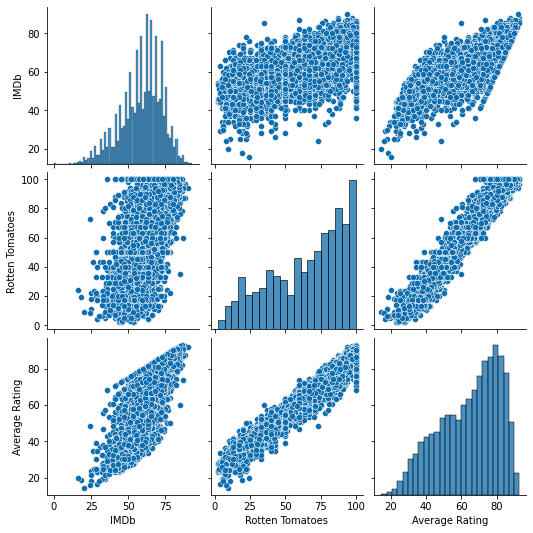

In [ ]:
#@title Use pair plot to determine which rating is best to use for analysis, and drop the column not used to limit the number of nulls (i.e. keep as many records as possible.)
#use pair plot to determine which rating to use
sns.pairplot(svod_df_clean[['IMDb', 'Rotten Tomatoes', 'Average Rating']])

Based on the pair plot above, we can see that the Rotten Tomatoes score and Average Rating score are skewed upward, and that the IMDb score is most normally distributed. For this reason, the IMDb score is best to use for analysis. We will now drop the Rotten Tomatoes and Average Rating columns to preserve data records.

In [ ]:
#drop columns Rotten Tomatoes and Average Rating
svod_df_clean = svod_df_clean.drop(columns=['Rotten Tomatoes', 'Average Rating'])

In [ ]:
#if we drop all records that have null values in any column 
#(leaving us with only complete records) how many records will we have?
svod_df_filtered = svod_df_clean.dropna()
explore_df(svod_df_filtered)

Dataframe: svod_df_filtered
The shape of this DataFrame is (7046, 14)
The columns in this DataFrame are Index(['Title', 'Year', 'Age', 'IMDb', 'Netflix', 'Hulu', 'Prime Video',
       'Disney+', 'Directors', 'Genres', 'Country', 'Language', 'Runtime',
       'Total Platforms'],
      dtype='object')
The info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7046 entries, 0 to 16740
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            7046 non-null   object 
 1   Year             7046 non-null   int64  
 2   Age              7046 non-null   object 
 3   IMDb             7046 non-null   float64
 4   Netflix          7046 non-null   int64  
 5   Hulu             7046 non-null   int64  
 6   Prime Video      7046 non-null   int64  
 7   Disney+          7046 non-null   int64  
 8   Directors        7046 non-null   object 
 9   Genres           7046 non-null   object 
 10  Country          7046 no

## Business of Apps Dataset - Webscrape

Ye Olde Webscrape

*Note: The variable ```html_doc``` below is not a live link, but a snippet of html code that has been processed with Beautiful Soup and an html parser. This is to avoid multiple scrapes of the website while still being able to parse the CSS code for valuable data. The webpage can be found [here](https://www.businessofapps.com/data/video-streaming-app-market/).



In [ ]:
#@title Pull in html code, convert into bs object ```soup```, and print 'prettified' soup object to inspect elements
#pull US Video Streaming App Subscriber Usage data from Business of Apps site
#use bs4 and html.parser to parse the CSS for easier data processing - print 'pretty' soup
html_doc = '''
<h3>US Video Streaming App Usage</h3><div class="infogram-embed" data-id="e7a570fe-ddc8-43e9-889a-44452fd18f1f" data-type="interactive" data-title="US video streaming users"></div><p></p><table style="width: 100%; height: 92px;"><tbody><tr style="height: 23px;"><td style="background-color: #f0f0f0; height: 23px; width: 49.2586%;" width="301"><strong><span style="font-size: 12pt;">App Name</span></strong></td><td style="background-color: #f0f0f0; height: 23px; width: 49.5881%;" width="301"><strong><span style="font-size: 12pt;">US Video Streaming App Usage</span></strong></td></tr><tr style="height: 23px;"><td style="width: 49.2586%;" width="301"><span style="font-size: 12pt;"><span style="font-size: 12pt;">YouTube</span></span></td><td style="width: 49.5881%;" width="301"><span style="font-size: 12pt;"><span style="font-size: 12pt;">150 million</span></span></td></tr><tr style="height: 23px;"><td style="background-color: #f0f0f0; height: 23px; width: 49.2586%;"><span style="font-size: 12pt;">TikTok</span></td><td style="background-color: #f0f0f0; height: 23px; width: 49.5881%;"><span style="font-size: 12pt;">80 million</span></td></tr><tr style="height: 23px;"><td style="width: 49.2586%;" width="301"><span style="font-size: 12pt;"><span style="font-size: 12pt;">Netflix</span></span></td><td style="width: 49.5881%;" width="301"><span style="font-size: 12pt;"><span style="font-size: 12pt;">75 million</span></span></td></tr><tr style="height: 23px;"><td style="background-color: #f0f0f0; height: 23px; width: 49.2586%;"><span style="font-size: 12pt;">Disney+</span></td><td style="background-color: #f0f0f0; height: 23px; width: 49.2586%;"><span style="font-size: 12pt;"><span style="font-size: 12pt;">45 million</span></span></td></tr><tr style="height: 23px;"><td style="width: 49.2586%;" width="301"><span style="font-size: 12pt;">Amazon Prime Video</span></td><td style="width: 49.2586%;" width="301"><span style="font-size: 12pt;">40 million</span></td></tr><tr style="height: 23px;"><td style="background-color: #f0f0f0; height: 23px; width: 49.2586%;"><span style="font-size: 12pt;">Twitch</span></td><td style="background-color: #f0f0f0; height: 23px; width: 49.2586%;"><span style="font-size: 12pt;">35 million</span></td></tr><tr style="height: 23px;"><td style="width: 49.2586%;" width="301"><span style="font-size: 12pt;">Hulu</span></td><td style="width: 49.2586%;" width="301"><span style="font-size: 12pt;">35 million</span></td></tr><tr style="height: 23px;"><td style="background-color: #f0f0f0; height: 23px; width: 49.2586%;"><span style="font-size: 12pt;">Apple TV+</span></td><td style="background-color: #f0f0f0; height: 23px; width: 49.2586%;"><span style="font-size: 12pt;">15 million</span></td></tr></tbody></table>
'''
soup = BeautifulSoup(html_doc, 'html.parser')
print(soup.prettify())

<h3>
 US Video Streaming App Usage
</h3>
<div class="infogram-embed" data-id="e7a570fe-ddc8-43e9-889a-44452fd18f1f" data-title="US video streaming users" data-type="interactive">
</div>
<p>
</p>
<table style="width: 100%; height: 92px;">
 <tbody>
  <tr style="height: 23px;">
   <td style="background-color: #f0f0f0; height: 23px; width: 49.2586%;" width="301">
    <strong>
     <span style="font-size: 12pt;">
      App Name
     </span>
    </strong>
   </td>
   <td style="background-color: #f0f0f0; height: 23px; width: 49.5881%;" width="301">
    <strong>
     <span style="font-size: 12pt;">
      US Video Streaming App Usage
     </span>
    </strong>
   </td>
  </tr>
  <tr style="height: 23px;">
   <td style="width: 49.2586%;" width="301">
    <span style="font-size: 12pt;">
     <span style="font-size: 12pt;">
      YouTube
     </span>
    </span>
   </td>
   <td style="width: 49.5881%;" width="301">
    <span style="font-size: 12pt;">
     <span style="font-size: 12pt;">
      150

In [ ]:
#@title Use the parsed html from the soup object to turn the data in the CSS tags into a dataframe, ```platform_usage_df```
#initiate lists for streaming_service and platform_usage variables
streaming_services = []
platform_usage = []

#use a list comprehension to isolate span tags within td tags
span_tags = [span for span in soup.select('td > span')]

#use a for loop to iterate over span tags and clean data for use
for s in span_tags:
  span1_markup_string_index_position = len('<bound method Tag.get_text of <span style="font-size: 12pt;">') #create variable to locate the index position of this markup in the text to eventually slice and strip it
  s_string = str(s.get_text) #convert s tags from bs4 tag elements to strings for processing with string methods
  s_string_span1_stripped = s_string[(span1_markup_string_index_position):] #slice string (using markup_string_index_position variable defined above as the index position) to remove first span tag
  #use conditional logic to determine if string begins with additional span markup to strip
  if s_string_span1_stripped[0] == '<' :
    span2_markup_string_index_position = len('<span style="font-size: 12pt;">')
    s_string_span1_stripped = s_string_span1_stripped[span2_markup_string_index_position: ]
  #use find string method to locate index and strip markup
  end_string_markup_index_position = s_string_span1_stripped.find('<')
  clean_string = s_string_span1_stripped[:end_string_markup_index_position]
  #use conditional statement to strip excess alpha characters at the end of the subscriber counts
  if not clean_string[0].isalpha():
    end_string_markup_index_position = clean_string.find(' million')
    clean_string = clean_string[ :end_string_markup_index_position]
    clean_float = float(clean_string) #convert clean_float from string to float for easier analysis later on
    platform_usage.append(clean_float) #add floats to global list variable platform_usage
  else:
    streaming_services.append(clean_string) #for other strings that do not contain numbers, append them to global list variable streaming_services

#initiate empty list to store clean svod subscriber data dictionaries
subscriber_usage_data = []

#create list of tuples
subscriber_tuples_z = zip(streaming_services, platform_usage)
subscriber_tuples = list(subscriber_tuples_z) #convert zip object to list

#use for loop to populate dictionaries
for a,b in subscriber_tuples:
  subscriber_dictionary = {'Streaming Service' : a, 'Usage' : b }
  subscriber_usage_data.append(subscriber_dictionary)

#turn list of dictionaries into df
platform_usage_df = pd.DataFrame(subscriber_usage_data)
platform_usage_df.to_csv('platform_usage_df.csv')

In [ ]:
#use the function we defined earlier for inspecting df's to check out our subscriber data
explore_df(platform_usage_df)

Dataframe: platform_usage_df
The shape of this DataFrame is (8, 2)
The columns in this DataFrame are Index(['Streaming Service', 'Usage'], dtype='object')
The info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Streaming Service  8 non-null      object 
 1   Usage              8 non-null      float64
dtypes: float64(1), object(1)
memory usage: 256.0+ bytes
None
The first 5 rows in this DataFrame are     Streaming Service  Usage
0             YouTube  150.0
1              TikTok   80.0
2             Netflix   75.0
3             Disney+   45.0
4  Amazon Prime Video   40.0




In [ ]:
#create df with only platforms we are interested in
platform_usage_df_clean = platform_usage_df[platform_usage_df['Streaming Service'].isin(['Netflix', 'Disney+', 'Amazon Prime Video', 'Hulu'])]
explore_df(platform_usage_df_clean)

Dataframe: platform_usage_df_clean
The shape of this DataFrame is (4, 2)
The columns in this DataFrame are Index(['Streaming Service', 'Usage'], dtype='object')
The info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 2 to 6
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Streaming Service  4 non-null      object 
 1   Usage              4 non-null      float64
dtypes: float64(1), object(1)
memory usage: 96.0+ bytes
None
The first 5 rows in this DataFrame are     Streaming Service  Usage
2             Netflix   75.0
3             Disney+   45.0
4  Amazon Prime Video   40.0
6                Hulu   35.0




## Resulting DataFrames from Sources




> ReelGood Data from CSV

*   `svod_df` - full dataframe from source 
*   `svod_df_clean` - cleaned dataframe containing null values with column added for total platforms
*   `svod_df_filtered` - cleaned dataframe containing only non null values

> Business of Apps Data from Webscrape

*   `platform_usage_df_clean` - cleaned dataframe containing only non null values of the four platforms we are analyzing


# Explore Data

## Are most movies available on multiple platforms?

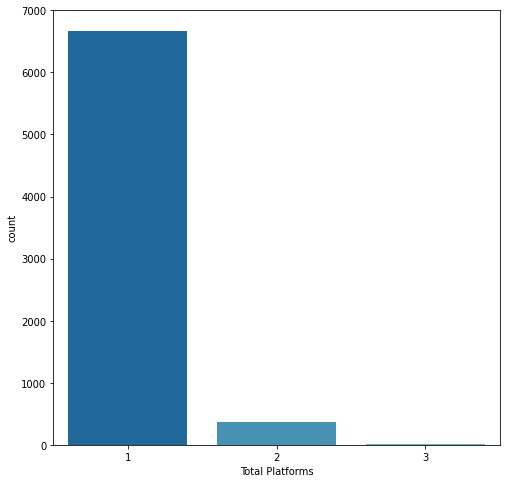

In [ ]:
#@title Count of titles in 1, 2, 3, or all 4 platforms { vertical-output: true }
#use a count plot to show if most movies are on 1, 2, or 3 platforms
plt.figure(figsize = (8,8))
sns.countplot(x = svod_df_filtered['Total Platforms'])

The overwhelming majority of titles in this set are only found on one platform - that is most of the movies on any given platform are unique to that platform.

## How many titles does each platform have?

In [ ]:
#@title Define function, ```create_sum_df```, to create a df to sum titles per platform to visualize. Make ```sum_df``` a global variable so it can be used in later analysis.
#define function to create df to sum titles per platform to visualize
def create_sum_df(df, group_by_list):
  
  sum_list_of_dictionaries = []
    
  for i in group_by_list:
    sum = df[f'{i}'].sum()
    dictionary = {'Category': i, 'Sum': sum}
    sum_list_of_dictionaries.append(dictionary)
  
  global sum_df
  sum_df = pd.DataFrame(sum_list_of_dictionaries)
  
  plt.figure(figsize = (8,8))
  sns.barplot(x="Category", y="Sum", palette="GnBu", data=sum_df.sort_values(by='Sum', ascending = False))
  return sum_df

,Category,Sum
0,Netflix,1609
1,Hulu,567
2,Prime Video,4761
3,Disney+,489


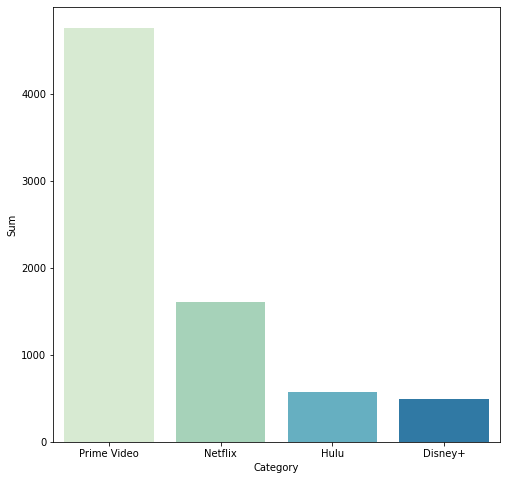

In [ ]:
#@title Execute ```create_sum_df``` function to create dataframe with the sum of available titles for each platform { vertical-output: true }
#use create_titles_sum_df function
platforms = ['Netflix', 'Hulu', 'Prime Video', 'Disney+']
create_sum_df(svod_df_filtered, platforms)

Far and away Amazon Prime has the biggest offering of movie titles - with Netflix coming in second, Hulu in third, and Disney+ in fourth. It is worth noting that roughly 30% of Amazon Prime's movie catalog is rent or buy only.

# Analyze

## Quality or Quantity?

We have established that Amazon Prime has the largest offering of movie titles - followed by Netflix, Hulu, then Disney+. But what about the quality of movies offered on each streaming platform?

In [ ]:
#@title Define function, ```create_avg_df```, to find the average IMDb rating per platform, transform into a df, then create a vizualization. Make ```avg_df``` a global variable so it can be used in later analysis.
#define function to create df to sum titles per platform to visualize
def create_avg_df(df, group_by_list):
  
  list_of_dictionaries = []
    
  for i in group_by_list:
    avg = df.iloc[(df[f'{i}'] == 1).values]['IMDb'].mean()
    dictionary = {'Category': i, 'Average Rating': avg}
    list_of_dictionaries.append(dictionary)
  
  global avg_df
  avg_df = pd.DataFrame(list_of_dictionaries)
  
  plt.figure(figsize = (8,8))
  sns.barplot(x="Category", y="Average Rating", palette="GnBu", data=avg_df.sort_values(by='Average Rating', ascending = False))
  return avg_df

,Category,Average Rating
0,Netflix,62.873835
1,Hulu,61.917108
2,Prime Video,56.268431
3,Disney+,63.993865


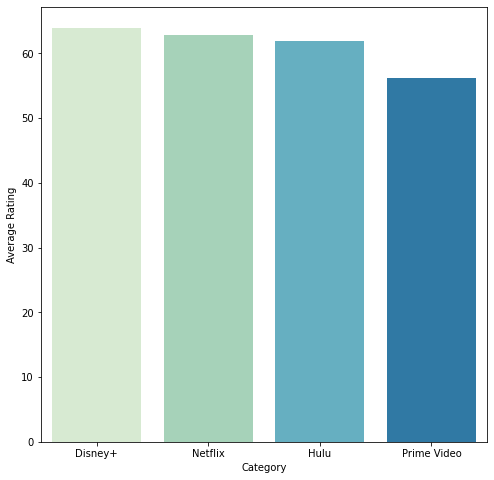

In [ ]:
#@title Execute function ```create_avg_df``` to create dataframe with the average IMDb rating per platform and visualize { vertical-output: true }
#use create_titles_sum_df function with global list variable platforms, created above
create_avg_df(svod_df_filtered, platforms)

Interesting that these are in very close descending order as the number of titles - Could these be correlated?

In [ ]:
#@title Determine whether or not there is correlation between the number of movie titles a platform offers and its average IMBd rating.
#determine the correlation and statistical significance of the correlation
titles_rating_tuple = stats.pearsonr(avg_df['Average Rating'], sum_df['Sum'])
print(f'The correlation between Sum of Titles and Average Rating is {titles_rating_tuple[0]}' + '\n' + f'The p-value of this correlation is {titles_rating_tuple[1]}')

The correlation between Sum of Titles and Average Rating is -0.9437677976851071
The p-value of this correlation is 0.0562322023148929


The correlation coefficient is -0.94, which is very close to -1. This indicates that the two variables in these sample populations are highly negatively correlated. However, with a p-value of 0.056, this correlation is not significant at the p < 0.05 level. 

That is to say, there is a 5.6% chance that you would get a correlation coefficient this high or higher in the overall population due to random chance. For this reason, we cannot reasonably generalize this correlation to the entire population.


---


Let's take a closer look at Amazon Prime: This platform has the largest offering of titles but the lowest average IMBd rating. Is Amazon Prime's average IMBd rating statistically lower than the other platforms?

In [ ]:
#@title Conduct a t-test of Amazon Prime's average IMBd rating against the other platform's average IMBd rating to test for statistical significance.
#to run the test, call the ttest_1samp from scipy
amazon_df = svod_df_filtered.iloc[(svod_df_filtered['Prime Video'] == 1).values]
not_amazon_df = svod_df_filtered.iloc[(svod_df_filtered['Prime Video'] == 0).values]
rating_ttest = stats.ttest_ind(amazon_df['IMDb'], not_amazon_df['IMDb'])
print(f'The t-statistic is {rating_ttest.statistic}' + '\n' + f'and the p-value is {rating_ttest.pvalue}')

The t-statistic is -20.654352247810216
and the p-value is 4.570182091018959e-92


Clearly with a t-stat of -20.65 and a p-value well below 0.05, Amazon Prime's average IMBd rating is statistically lower than the rest of the platforms. 

Now that we have determined statistical significance, let's determine the effect size.

In [ ]:
#@title Calculate Cohen's d effect size of Amazon Prime's ratings compared to the other platforms.
#calculate cohens_d = (sample_mean_a - sample_mean_b)/pooled_standard_deviation 
variance_amazon = statistics.stdev(amazon_df['IMDb'])**2
variance_not_amazon = statistics.stdev(not_amazon_df['IMDb'])**2
pooled_standard_deviation = math.sqrt((variance_amazon + variance_not_amazon)/2)
cohens_d = (amazon_df['IMDb'].mean() - not_amazon_df['IMDb'].mean()) / pooled_standard_deviation
print(f'The Cohen\'s d effect size is {cohens_d}')

The Cohen's d effect size is -0.5481805427971888


A Cohen's d of -0.55 means that Amazon Prime's average IMDb rating is 0.55 standard deviations below the average IMBd score of the other platforms. This is a moderate effect size.

In other words, Amazon Prime has a lot of movies to choose from, however the movies tend to have lower IMBd ratings than the rest of the platforms.



The mean difference at the 95% confidence interval is between 6.214402883008631 and 7.397531612116566.


[Text(0, 0, 'All Other Platforms'), Text(0, 0, 'Prime Video')]

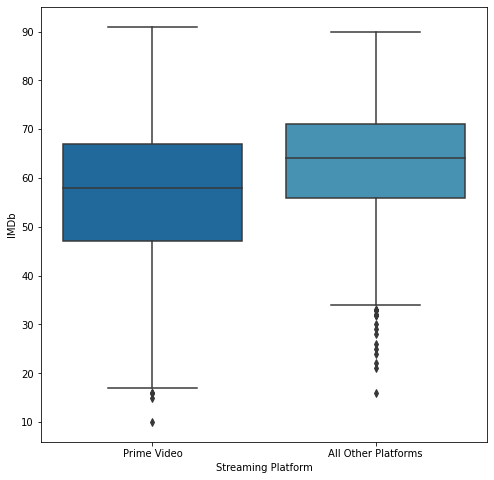

In [ ]:
#@title For further illustration, calculate the mean difference at the 95% confidence interval, and visualize with a boxplot.
#define function to prent and print the confidence interval of two iterables
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    print('The mean difference at the 95% confidence interval is between '+str(ci_lower)+' and '+str(ci_upper)+'.')

#call confidence interval function with amazon df and other platforms (not amazon) df
get_95_ci(amazon_df['IMDb'], not_amazon_df['IMDb'])

#vizualize with a boxplot
plt.figure(figsize = (8,8))
g = sns.boxplot(x ='Prime Video', y ='IMDb', order=[1, 0], data=svod_df_filtered)
g.set_xlabel('Streaming Platform')
g.set_xticks([1,0])
g.set_xticklabels(['All Other Platforms', 'Prime Video'])



## What does the audience prefer?



We know that some platforms have more titles while other platforms have better titles (according to IMBd at least!) Now, let's look at which platform is most popular among its subscribers.

In order to judge how popular a platform is, we will analyze the active usage (in the millions) of the platform instead of the amount of subscribers. This way, we don't include inactive subscribers - For example Amazon Prime members who have an account but don't use its video streaming feature.

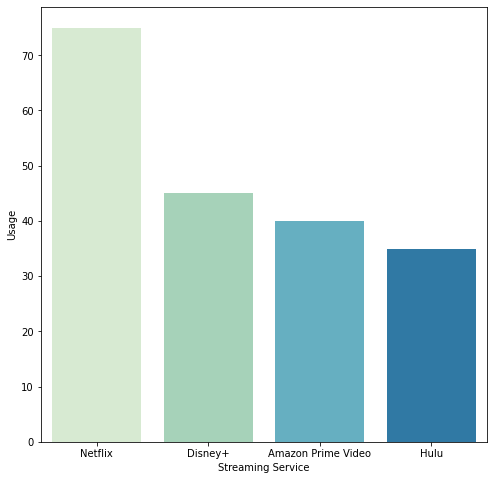

In [ ]:
#@title Create a visualization for active users per platform

plt.figure(figsize = (8,8))
sns.barplot(x="Streaming Service", y="Usage", palette="GnBu", data=platform_usage_df_clean.sort_values(by='Usage', ascending = False))


Could it be that Netflix has found the perfect balance between number of titles to offer and popular titles worth paying extra for? They are the oldest of the movie streaming services, and seem to have mastered the art of curating the ideal amount of quality and quantity for the consumer. 

One limitation of this data set is that it does not show the number of original studio productions produced by each streaming platform, which has risen in popularity in recent years - Is Robert De Niro's performance in *The Irishman* responsible for Netflix's sizable lead in viewers? Will *Baby Yoda* close that gap? Unfortunately we can't determine that from this data set!

---



As web based video streaming continues to mature as an industry, it will become increasingly important for streaming platforms to understand what draws viewers and how they compare to competitors from the perspective of the consumer. This data dive of four popular streaming services provides insight into those comparisons.